In [1]:
import pandas as pd
import re
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("/kaggle/input/text-document-classification-dataset/df_file.csv")

In [3]:
print(df.shape)

(2225, 2)


In [4]:
df.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


# Cleaning The data

**Rename columns**

In [5]:
df.columns=df.columns.str.lower()

**Check Null values**

In [6]:
df['text'].isna().sum()

0

**Remove digits**

In [7]:
def remove_digits(text):
    return re.sub('\d+','',text)

In [8]:
df['cleaned_text']=df['text'].apply(lambda x:remove_digits(x))

**Remove punctuations**

In [9]:
import string
exclude=string.punctuation

In [10]:
def remove_punc(text):
    for i in exclude:
        text.replace(i,'')
    return text   

In [11]:
df['cleaned_text']=df['cleaned_text'].apply(lambda x:remove_punc(x))

**Remove Stopwords**

In [12]:
from nltk.corpus import stopwords
stopwords=stopwords.words('english')

def remove_stopwords(text):
    new=' '.join(word for word in text.split() if word.lower not in stopwords)
    return new

In [13]:
df['cleaned_text']=df['cleaned_text'].apply(lambda x:remove_stopwords(x))

**Remove emojis**

In [14]:
import emoji
df['cleaned_text']=df['cleaned_text'].apply(emoji.demojize)

# Prepare data for the RNN Model

**build vocabulary for the most appearance words**

In [15]:
# build vocabulary for the most appearance words
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_sz = 10000

tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(df['cleaned_text'])


**Split data**

In [16]:
x=df['cleaned_text']
y=df['label']

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

**Word Embedding**

In [18]:
x_train_seq = tok.texts_to_sequences(x_train)
x_test_seq = tok.texts_to_sequences(x_test)

**calculate maxmium lengh of sequence**

In [19]:
from nltk.tokenize import word_tokenize

def get_max_len(texts):
  return max([len(word_tokenize(text)) for text in texts])
    
maxlen = get_max_len(df['cleaned_text'])

**Pad sequences to ensure that all input sequences have the same length**

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train_seq, maxlen=maxlen, padding='post', truncating='post')  
x_test = pad_sequences(x_test_seq, maxlen=maxlen, padding='post', truncating='post')

# RNN

In [21]:
embedding_size = 100

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization
from keras.layers import Embedding
from keras.layers import SimpleRNN


# Model: Enhanced RNN with multiple layers
model = Sequential()
model.add(Embedding(vocab_sz + 1, embedding_size, mask_zero=True, input_length=maxlen))

# Add the first RNN layer
model.add(SimpleRNN(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))  # Return sequences to pass to the next RNN layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add a second RNN layer
model.add(SimpleRNN(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a third RNN layer
model.add(SimpleRNN(100,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a fully connected layer
model.add(Dense(64, activation='relu'))  # Intermediate dense layer for more learning capacity
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout for dense layer

# Output layer
model.add(Dense(5, activation='softmax'))  # For classification

model.build(input_shape=(None, maxlen)) # None for batch size, maxlen for sequence length
# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 4950, 100)      │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 4950, 100)      │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4950, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 4950, 100)      │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4950, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,067,445 (4.07 MB)

 Trainable params: 1,067,317 (4.07 MB)

 Non-trainable params: 128 (512.00 B)

In [23]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

In [24]:
checkpoint = EarlyStopping(monitor='val_loss',patience = 10 ,mode='max',restore_best_weights=True)
callbacks_lst = [checkpoint]

In [25]:
history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=80,
          validation_split=0.2,
          callbacks=callbacks_lst)

Epoch 1/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 379s 16s/step - accuracy: 0.1934 - loss: 2.4700 - val_accuracy: 0.1601 - val_loss: 1.6757
Epoch 2/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 379s 16s/step - accuracy: 0.1943 - loss: 2.2233 - val_accuracy: 0.1938 - val_loss: 1.6557
Epoch 3/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 372s 16s/step - accuracy: 0.2141 - loss: 2.0678 - val_accuracy: 0.1938 - val_loss: 1.6605
Epoch 4/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 373s 16s/step - accuracy: 0.2036 - loss: 2.0044 - val_accuracy: 0.1657 - val_loss: 1.6730
Epoch 5/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 373s 16s/step - accuracy: 0.2114 - loss: 1.9568 - val_accuracy: 0.1994 - val_loss: 1.6547
Epoch 6/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 372s 16s/step - accuracy: 0.2079 - loss: 1.9249 - val_accuracy: 0.2191 - val_loss: 1.6205
Epoch 7/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 370s 16s/step - accuracy: 0.1872 - loss: 1.9089 - val_accuracy: 0.2416 - val_loss: 1.6438
Epoch 8/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 374s 16s/step - accuracy: 0.1843 - loss: 1.8710 - val_accuracy: 0.

In [26]:
loss, accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1941 - loss: 1.6826
Test Loss: 1.6863594055175781
Test Accuracy: 0.19550561904907227


In [27]:
model.evaluate(x_train,y_train)

56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.2093 - loss: 1.6708


[1.6681922674179077, 0.2140449434518814]

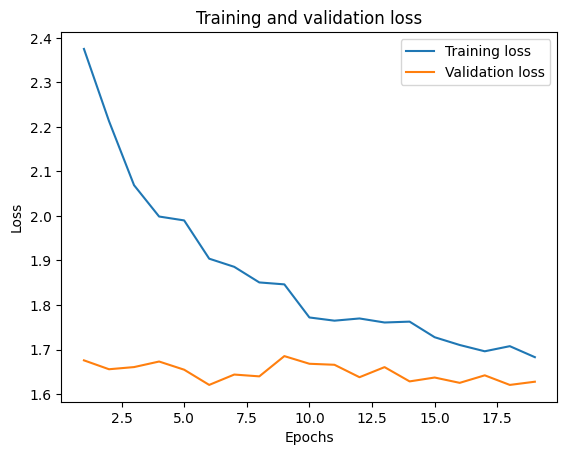

In [28]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

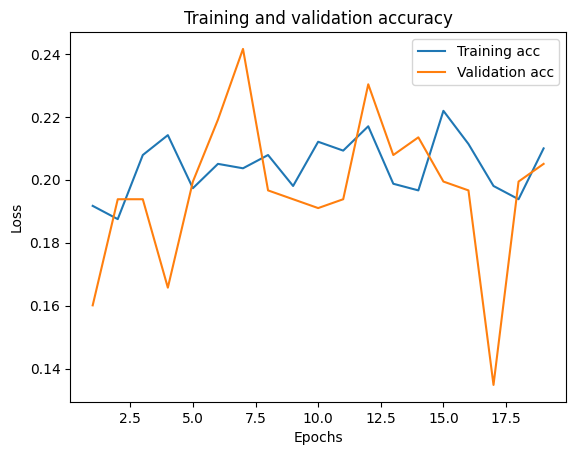

In [29]:

plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# LSTM

In [30]:
from keras.layers import LSTM

embedding_size = 100

# Model: Enhanced LSTM with multiple layers
model = Sequential()
model.add(Embedding(vocab_sz + 1, embedding_size, mask_zero=True, input_length=maxlen))

# Add the first LSTM layer
model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))  # Return sequences to pass to the next LSTM layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add a second LSTM layer
model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a third LSTM layer
model.add(LSTM(100,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a fully connected layer
model.add(Dense(64, activation='relu'))  # Intermediate dense layer for more learning capacity
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))  # For classification

model.build(input_shape=(None, maxlen)) # None for batch size, maxlen for sequence length
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 4950, 100)      │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4950, 100)      │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4950, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4950, 100)      │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4950, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,248,345 (4.76 MB)

 Trainable params: 1,248,217 (4.76 MB)

 Non-trainable params: 128 (512.00 B)

In [31]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

In [32]:
checkpoint = EarlyStopping(monitor='val_loss',patience = 10 ,mode='max',restore_best_weights=True)
callbacks_lst = [checkpoint]

In [33]:
history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=50,
          validation_split=0.2,
          callbacks=callbacks_lst)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 604s 26s/step - accuracy: 0.2330 - loss: 1.6120 - val_accuracy: 0.3652 - val_loss: 1.5964
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 595s 26s/step - accuracy: 0.4406 - loss: 1.3011 - val_accuracy: 0.5056 - val_loss: 1.5213
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 603s 26s/step - accuracy: 0.7440 - loss: 0.7145 - val_accuracy: 0.7669 - val_loss: 1.3499
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 605s 26s/step - accuracy: 0.9050 - loss: 0.2967 - val_accuracy: 0.8118 - val_loss: 1.1885
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 607s 26s/step - accuracy: 0.9635 - loss: 0.1361 - val_accuracy: 0.7893 - val_loss: 1.0332
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 613s 27s/step - accuracy: 0.9626 - loss: 0.1081 - val_accuracy: 0.7781 - val_loss: 0.9311
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 608s 26s/step - accuracy: 0.9808 - loss: 0.0662 - val_accuracy: 0.8034 - val_loss: 0.8086
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 615s 27s/step - accuracy: 0.9962 - loss: 0.0367 - val_accuracy: 0.

In [34]:
loss, accuracy = model.evaluate(x_train, y_train)

print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy}")


56/56 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.3995 - loss: 1.5928
Train Loss: 1.5933992862701416
Train Accuracy: 0.3943820297718048


In [35]:
loss, accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.3684 - loss: 1.5956
Test Loss: 1.5965845584869385
Test Accuracy: 0.3595505654811859


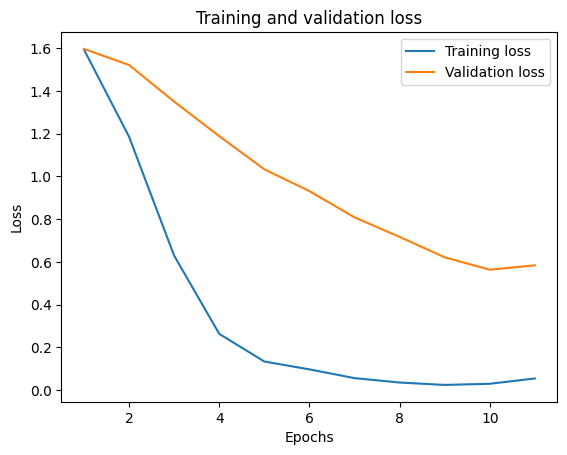

In [36]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

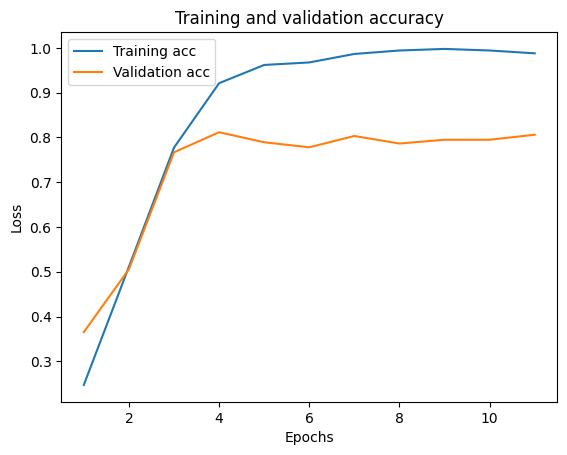

In [37]:

plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()